<a href="https://colab.research.google.com/github/samratkar/samratkar.github.io/blob/main/GPT_OSS_Customer_Support_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (2) Local Inference

### Part 1: Using HuggingFace Transformers

In [ ]:
!pip install -q --upgrade accelerate transformers kernels



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "openai/gpt-oss-20b"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="auto",
)

messages = [
    {"role": "user", "content": "How many rs are in the word 'strawberry'?"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
).to(model.device)

generated = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(generated[0][inputs["input_ids"].shape[-1]:]))


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

MXFP4 quantization requires triton >= 3.4.0 and triton_kernels installed, we will default to dequantizing the model to bf16


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

model-00000-of-00002.safetensors:   0%|          | 0.00/4.79G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

<|channel|>analysis<|message|>We have a user asking: "How many rs are in the word 'strawberry'?" The question is straightforward: Count the letter 'r' in the word "strawberry". Let's see: S T R A W B E R R Y. That has r's at positions 3, 8, 9? Let’s write the letters: S (1), T (2), R (3), A (4), W (5), B (6


In [ ]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
from datasets import load_dataset

# ArXiv ML Documents
#docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]
raw_docs = load_dataset("Tobi-Bueck/customer-support-tickets")["train"]["body"]

# 2. Keep only the non-None strings
docs = [d for d in raw_docs if isinstance(d, str) and d.strip() != ""]


README.md: 0.00B [00:00, ?B/s]

dataset-tickets-multi-lang-4-20k.csv:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from bertopic.representation import TextGeneration, KeyBERTInspired


MODEL_ID = "openai/gpt-oss-20b"       # pick any causal-LM available locally / on HF Hub

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype="auto",
)
model.eval()

text_gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=16,                # keep labels short
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id,   # avoids warning if no pad_token
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
# A few-shot prompt with two examples to guide the model's output
PROMPT = """I have a topic that contains the following documents:
- "My credit card was charged twice for the same subscription."
- "I received an invoice with an incorrect amount."
- "The payment failed during checkout but my account was still debited."

The topic is described by the following keywords: 'billing, charge, invoice, payment, subscription, error'.

Based on the above information, give me a short, concise topic label of at most 5 words.
A: Customer Billing and Payment Issues
---
I have a topic that contains the following documents:
- "The application crashes every time I try to export the file."
- "The user data is not syncing correctly between my devices."
- "There's a visual glitch on the main dashboard after the latest update."

The topic is described by the following keywords: 'bug, crash, sync, glitch, update, error'.

Based on the above information, give me a short, concise topic label of at most 5 words.
A: Software Bugs and Sync Errors
---
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, give me a short, concise topic label of at most 5 words.
A:
"""

# You then use this new PROMPT in your representation model
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": TextGeneration(model=text_gen, prompt=PROMPT),
}

In [ ]:

from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

[2025-08-06 11:25:44.281] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [ ]:
# Define sub-models
#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
#hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

# Allow clusters down to 50 points, use leaf extraction
hdbscan_model = HDBSCAN(
    min_cluster_size=650,
    min_samples=12,
    metric='euclidean',
    cluster_selection_method='leaf',
    prediction_data=True
)

[2025-08-06 11:25:46.697] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-08-06 11:25:50,906 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 11:25:51,054 - BERTopic - Dimensionality - Completed ✓
2025-08-06 11:25:51,056 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 11:25:51,232 - BERTopic - Cluster - Completed ✓
2025-08-06 11:25:51,242 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
2025-08-06 11:25:59,646 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,4089,-1_the_to_and_und,"[the, to, and, und, die, zu, in, ich, you, this]","[issue, billing, issues, problem, digital, sup...",[We have to create topic label of at most 5 wo...,[I am contacting you to report an unexpected b...
1,0,3692,0_und_die_zu_ich,"[und, die, zu, ich, sie, der, um, das, für, es]","[unterstützung, medizinischer, medizinische, k...",[We need to generate a short concise topic lab...,"[Sehr geehrte Kundensupport, ich schreibe Ihne..."
2,1,2506,1_the_to_and_issue,"[the, to, and, issue, data, this, be, we, have...","[analytics, investment, issue, update, updates...",[We need to produce a short concise topic labe...,"[To Whom It May Concern, I am contacting you t..."
3,2,2162,2_the_to_and_issue,"[the, to, and, issue, this, be, you, have, pro...","[saas, issue, unresolved, synchronization, upd...",[We have a set of documents all about integrat...,"[Dear Customer Support, I am writing to report..."
4,3,1888,3_to_the_and_security,"[to, the, and, security, data, medical, have, ...","[breaches, breach, vulnerabilities, patient, s...",[We need to find short concise topic label of ...,"[Customer Support, <br/>We are writing to repo..."
5,4,1424,4_and_the_to_you,"[and, the, to, you, project, for, management, ...","[saas, platform, workflow, support, collaborat...",[We need to give a short concise topic label o...,"[Dear Customer Support, I am inquiring about i..."
6,5,1147,5_investment_analytics_tools_to,"[investment, analytics, tools, to, you, and, d...","[investment, analytics, investments, insights,...",[We need to read the description: topic docume...,"[Dear Customer Support, I am reaching out to s..."
7,6,1144,6_medical_data_security_to,"[medical, data, security, to, and, on, for, yo...","[securing, confidentiality, hipaa, security, h...",[We need to produce a short concise topic labe...,"[Hello Customer Support, I am contacting you t..."
8,7,1078,7_digital_brand_to_and,"[digital, brand, to, and, strategies, growth, ...","[marketing, strategies, advice, insights, digi...",[We need to produce a short concise topic labe...,"[Customer Support, we are looking to inquire a..."
9,8,868,8_die_und_zu_ich,"[die, und, zu, ich, sie, um, der, digitalen, w...","[kundenservice, aktualisierung, digitalen, str...",[We need to analyze the prompt. We have a set ...,"[Sehr geehrte Kundenservice, ich schreibe Ihne..."


Calculating medoids: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it]


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': "Naturally we don't do a good job, since model is not instruction fine-tuned`"}>)

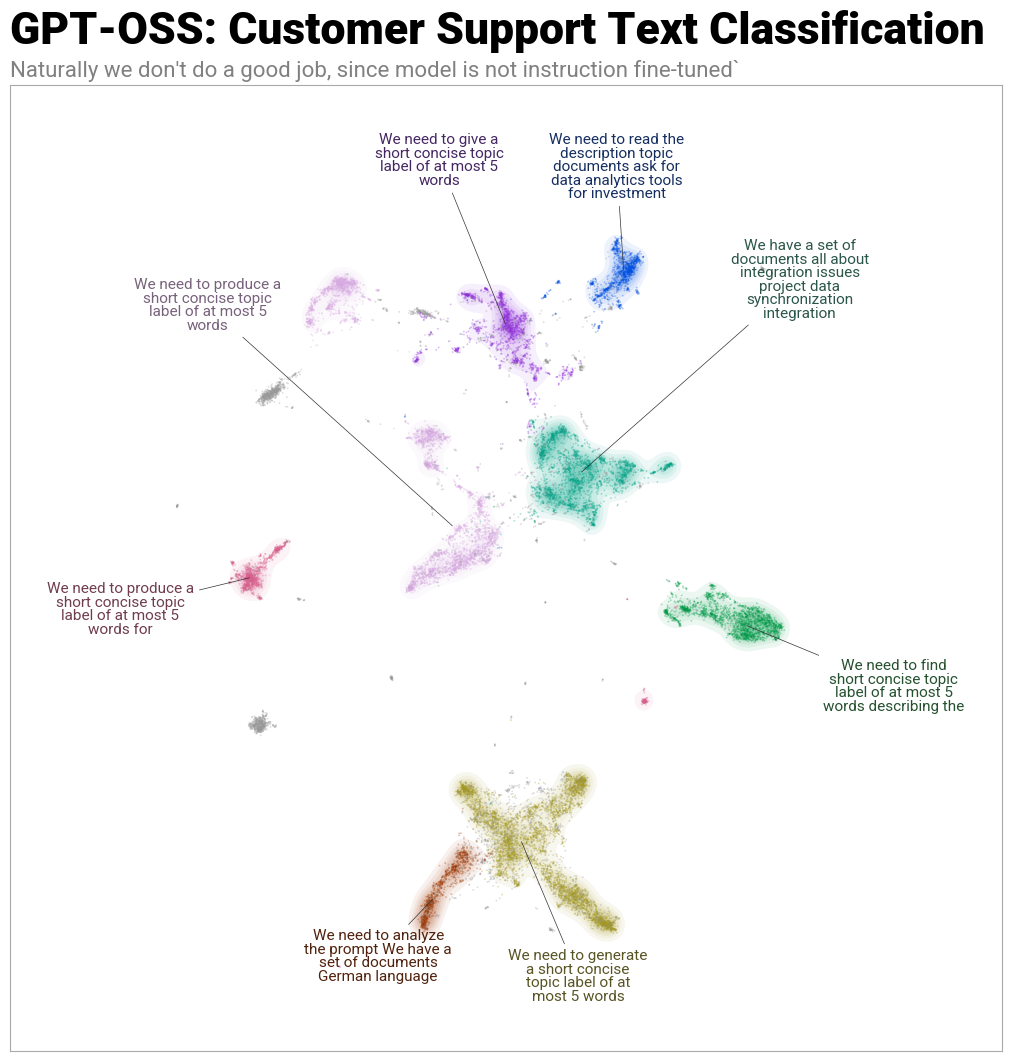

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="GPT-OSS: Customer Support Text Classification ",
    sub_title="Naturally we don't do a good job, since model is not instruction fine-tuned`",
    label_wrap_width=20,
    use_medoids=True
)